## Containment Index

For each simulated read, I define a containment index, which is a measure of how contained it is.  For a read which is contained, it is based on the extra length of the read which contains it.  Formally, if a read containing a given read R extends past the read by x bases on the left and y bases on the right, the containment index of R is the harmonic mean of x and y.  In the case of reads which are contained by multiple other reads, the maximum value of the containment index is used.  For reads which are not contained by another read, the containment index represents the minimum number of bases which would need to be removed from the ends of the read in order for some other read to contain it.  To distinguish these from contained reads and to maintain the property that a higher containment index is associated with a higher degree of containment, the index is multiplied by -1 for uncontained reads.

## Distribution of Containment Index
I simulated 30x coverage on a section of the human genome with length 5 Mbp and observed the distribution of the containment across these reads.  The length distribution drawn from was normally distributed with a mean of 15 kbp and a standard deviation of 1500 bp.  This dataset had 10001 reads, with 6266 of them being contained.  I  looked at the overall distribution, as well as the separate distributions among reads which my software determined to be contained or uncontained.

In [1]:
import matplotlib.pyplot as plt

fn = 'simulatedscores.txt'

buckets = [40 * i for i in range(-100, 100)]

xs = []

numContained,  numUncontained = 0, 0

nameToScore = dict()

with open(fn) as f:
    for line in f:
        tokens = line.split()
        curScore = int(tokens[1])
        xs.append(curScore)
        nameToScore[tokens[0]] = curScore
        if curScore >= 0:
            numContained += 1
        else:
            numUncontained += 1
                  
print('Number of contained reads: ' + str(numContained))
print('Number of uncontained reads: ' + str(numUncontained))

plt.hist(xs, bins = buckets)
plt.title('Containment Index')
plt.show()

Number of contained reads: 6225
Number of uncontained reads: 3786


<Figure size 640x480 with 1 Axes>

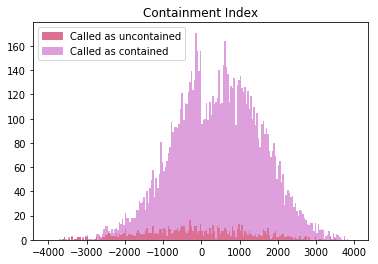

In [2]:
import matplotlib.patches as mpatches

yesVals = []
noVals = []

resultsfn = 'uncontained.txt'

yes = set()

with open(resultsfn) as f:
    for line in f:
        yes.add(line.split()[0])

for a in nameToScore:
    b = nameToScore[a]
    if a in yes:
        yesVals.append(b)
    else:
        noVals.append(b)
        
colors = ['palevioletred', 'plum']
        
plt.hist([yesVals, noVals], color = colors , bins = buckets, stacked = True)

labels = ['Called as uncontained', 'Called as contained']
legendHandles = []
for i in range(0, len(colors)):
    legendHandles.append(mpatches.Patch(color=colors[i], label=labels[i]))
plt.legend(handles=legendHandles)
plt.title('Containment Index')

plt.show()

## Containment Threshold
When determining which reads are contained, I use their min hash sketeches to determine a containment threshold for each read.  This represents the proportion of kmers in that read's sketch which are contained in some other read's sketch (taking the maximum proportion over all other reads).  Note that in general this  proportion will be low for  large kmers because of read errors preventing instances of a kmer from remaining identical.  Here I used 15-mers and filteredout reads with a containment threshold higher than 0.02.

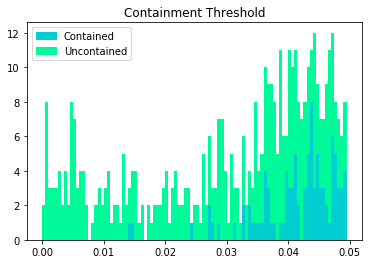

In [3]:
containedCt = []
uncontainedCt = []
nameToThreshold = dict()

ctFn = 'containment_debug.txt'

with open(ctFn) as f:
    for line in f:
        tokens = line.split()
        nameToThreshold[tokens[0]] = float(tokens[1])
        if nameToScore[tokens[0]] > 0:
            containedCt.append(float(tokens[1]))
        else:
            uncontainedCt.append(float(tokens[1]))
            

nlabels = ['Contained', 'Uncontained']
ncolors = ['darkturquoise', 'mediumspringgreen']

plt.hist([containedCt, uncontainedCt], color = ncolors, bins = [0.0005 * i for i in range(0, 100)], stacked = True)

nlh = []
for i in range(0, len(ncolors)):
    nlh.append(mpatches.Patch(color=ncolors[i], label=nlabels[i]))
plt.legend(handles=nlh)
plt.title('Containment Threshold')
plt.show()

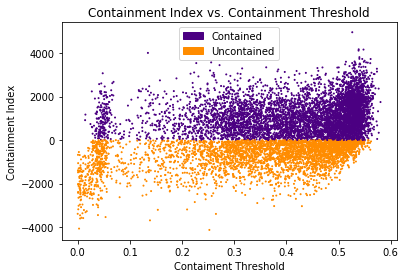

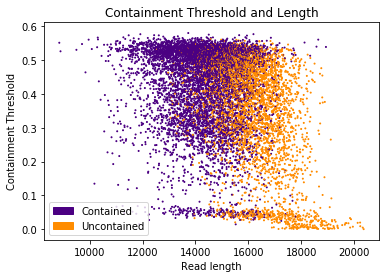

In [4]:
cts = []
cis = []
lens = []
colors = []
curColors = ['indigo', 'darkorange']
names = []

with open(ctFn) as f:
    for line in f:
        tokens = line.split()
        names.append(tokens[0])
        score = float(nameToScore[tokens[0]])
        cts.append(float(tokens[1]))
        lens.append(int(tokens[2]))
        cis.append(score)
        if score > 0:
            colors.append(curColors[0])
        else:
            colors.append(curColors[1])
            
nlh = []
for i in range(0, len(curColors)):
    nlh.append(mpatches.Patch(color=curColors[i], label=nlabels[i]))
plt.legend(handles=nlh)
plt.scatter(cts, cis, s = 1, c = colors)
plt.title('Containment Index vs. Containment Threshold')
plt.xlabel('Contaiment Threshold')
plt.ylabel('Containment Index')
plt.savefig('cict.png')
plt.show()
plt.clf()
plt.cla()
plt.close()

plt.scatter(lens, cts, s = 1, c = colors)
plt.legend(handles=nlh)
plt.xlabel('Read length')
plt.ylabel('Containment Threshold')
plt.title('Containment Threshold and Length')
plt.savefig('ctl.png')
plt.show()
plt.clf()
plt.cla()
plt.close()


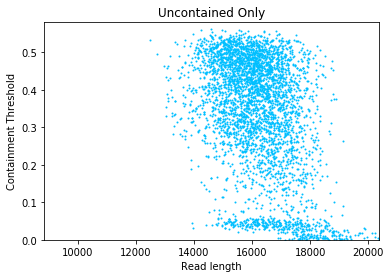

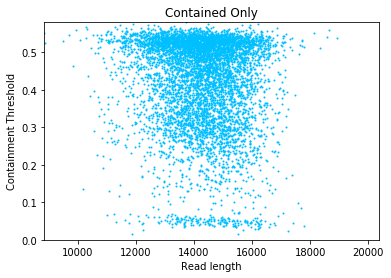

In [5]:
uncontainedCts = []
uncontainedLens = []

containedCts = []
containedLens = []
for i in range(len(cts)):
    if cis[i] < 0:
        uncontainedCts.append(cts[i])
        uncontainedLens.append(lens[i])
    else:
        containedCts.append(cts[i])
        containedLens.append(lens[i])
        
plt.scatter(uncontainedLens, uncontainedCts, s = 1, c = 'deepskyblue')
plt.title('Uncontained Only')
plt.xlabel('Read length')
plt.ylabel('Containment Threshold')
plt.xlim(min(lens), max(lens))
plt.ylim(min(cts), max(cts))
plt.show()
plt.clf()
plt.cla()
plt.close()

plt.scatter(containedLens, containedCts, s = 1, c = 'deepskyblue')
plt.title('Contained Only')
plt.xlabel('Read length')
plt.ylabel('Containment Threshold')
plt.xlim(min(lens), max(lens))
plt.ylim(min(cts), max(cts))
plt.show()
plt.clf()
plt.cla()
plt.close()

## Read Length vs. Containment Index
In many cases, people filter readsets by length to reduce the size of their dataset and remove the less useful short reads.  In general, shorter reads are more likely to be contained, but how well correlated are these metrics, and how well does filtering in this way remove contained reads while keeping uncontained reads?

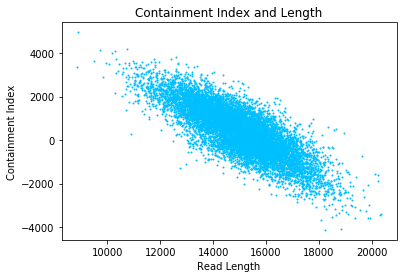

R^2 = 0.6523944297149179


In [6]:
import numpy as np

plt.scatter(lens, cis, s = 1, c = 'deepskyblue')
plt.title('Containment Index and Length')
plt.xlabel('Read Length')
plt.ylabel('Containment Index')
plt.show()
plt.clf()
plt.cla()
plt.close()

r = np.corrcoef(lens, cis)[0][1]
print('R^2 = ' + str(r*r))

Length threshold: 17069
Number called as uncontained: 823
Number called as contained: 9188


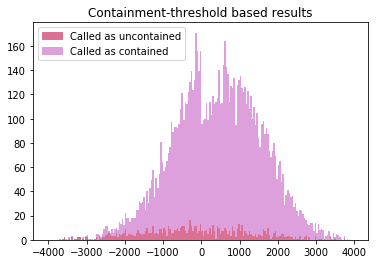

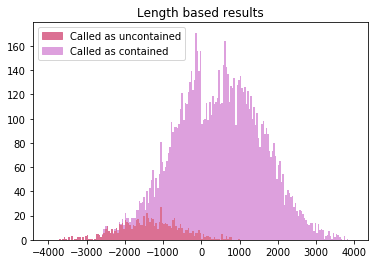

In [7]:
sortedLengths = sorted(lens)
numberContained = len(noVals)
lengthThreshold = sortedLengths[numberContained]
print('Length threshold: ' + str(lengthThreshold))

filteredYesVals = []
filteredNoVals = []
for i in range(0, len(lens)):
    a = names[i]
    b = nameToScore[a]
    if lens[i] >= lengthThreshold:
        filteredYesVals.append(b)
    else:
        filteredNoVals.append(b)
        
print('Number called as uncontained: ' + str(len(filteredYesVals)))
print('Number called as contained: ' + str(len(filteredNoVals)))

colors = ['palevioletred', 'plum']
labels = ['Called as uncontained', 'Called as contained']
legendHandles = []
for i in range(0, len(colors)):
    legendHandles.append(mpatches.Patch(color=colors[i], label=labels[i]))

plt.title('Containment-threshold based results')
plt.hist([yesVals, noVals], color = colors , bins = buckets, stacked = True)
plt.legend(handles=legendHandles)
plt.show()
plt.clf()
plt.cla()
plt.close()

plt.title('Length based results')
plt.hist([filteredYesVals, filteredNoVals], color = colors , bins = buckets, stacked = True)
plt.legend(handles=legendHandles)
plt.show()
plt.clf()
plt.cla()
plt.close()

## Combining Containment Threshold and Read Length
Based on the above results, read length is a much better proxy for containment index than the containment threshold is.  However, reads close to the average read length (15 kbp) tend to be far less correlated with read length.  In this case, incorporating the containment threshold may allow better filtering of these reads.  Here I try using a two-pass filter: first removing those reads which are very short (more  

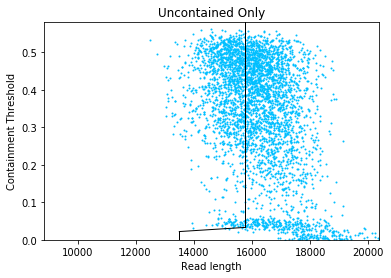

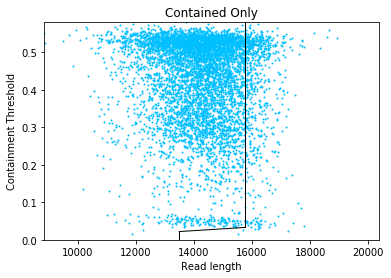

In [8]:
meanLength = 15000
stdLength = 1500
ctCutoff = 0.022
x1 = meanLength - stdLength * 1
x2 = meanLength + stdLength * 0.5
y1 = ctCutoff * 1
y2 = ctCutoff * 1.5
        
plt.scatter(uncontainedLens, uncontainedCts, s = 1, c = 'deepskyblue')
plt.title('Uncontained Only')
plt.xlabel('Read length')
plt.ylabel('Containment Threshold')
plt.xlim(min(lens), max(lens))
plt.ylim(min(cts), max(cts))
plt.plot([x1, x2], [y1, y2], color='k', linestyle='-', linewidth=1)
#plt.plot([0, x2], [y2, y2], color='k', linestyle='-', linewidth=1)
plt.plot([x2, x2], [y2, 1], color='k', linestyle='-', linewidth=1)
plt.plot([x1, x1], [0, y1], color='k', linestyle='-', linewidth=1)
plt.show()
plt.clf()
plt.cla()
plt.close()

plt.scatter(containedLens, containedCts, s = 1, c = 'deepskyblue')
plt.title('Contained Only')
plt.xlabel('Read length')
plt.ylabel('Containment Threshold')
plt.xlim(min(lens), max(lens))
plt.ylim(min(cts), max(cts))
plt.plot([x1, x2], [y1, y2], color='k', linestyle='-', linewidth=1)
#plt.plot([0, x2], [y2, y2], color='k', linestyle='-', linewidth=1)
plt.plot([x2, x2], [y2, 1], color='k', linestyle='-', linewidth=1)
plt.plot([x1, x1], [0, y1], color='k', linestyle='-', linewidth=1)
plt.show()
plt.clf()
plt.cla()
plt.close()

Number called as uncontained: 242
Number called as contained: 9769


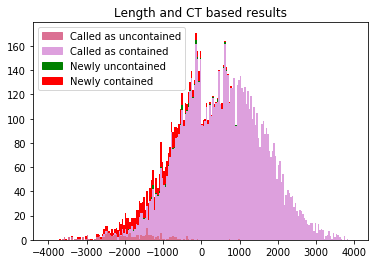

In [9]:
def lineFromPoints(x1, y1, x2, y2):
    slope = (y2 - y1) / (x2 - x1)
    intercept = y1 - x1 * slope
    return slope, intercept

numberContained = len(noVals)
lengthThreshold = sortedLengths[numberContained]

slope, intercept = lineFromPoints(x1, y1, x2, y2)

combinedYes = []
combinedNo = []
newKeep = []
newThrow = []
for i in range(0, len(lens)):
    a = names[i]
    b = nameToScore[a]
    ct = nameToThreshold[a]
    if lens[i] < x1:
        combinedNo.append(b)
    elif ct > lens[i] * slope + intercept:
        if lens[i] > lengthThreshold:
            newThrow.append(b)
        else:
            combinedNo.append(b)
    else:
        if lens[i] > lengthThreshold:
            combinedYes.append(b)
        else:
            newKeep.append(b)
            
numberContained = len(combinedNo) +  len(newThrow)
            
print('Number called as uncontained: ' + str(len(combinedYes) + len(newKeep)))
print('Number called as contained: ' + str(len(combinedNo) +  len(newThrow)))

colors = ['palevioletred', 'plum', 'green', 'red']
labels = ['Called as uncontained', 'Called as contained', 'Newly uncontained', 'Newly contained']
legendHandles = []
for i in range(0, len(colors)):
    legendHandles.append(mpatches.Patch(color=colors[i], label=labels[i]))
plt.title('Length and CT based results')
plt.hist([combinedYes, combinedNo, newKeep, newThrow], color = colors , bins = buckets, stacked = True)
plt.legend(handles=legendHandles)
plt.show()
plt.clf()
plt.cla()
plt.close()

New length threshold: 17907
Number called as uncontained: 242
Number called as contained: 9769


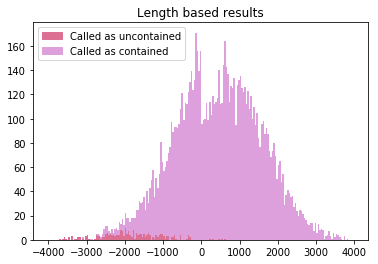

In [10]:
lengthThreshold = sortedLengths[numberContained]
print('New length threshold: ' + str(lengthThreshold))
filteredYesVals = []
filteredNoVals = []
for i in range(0, len(lens)):
    a = names[i]
    b = nameToScore[a]
    if lens[i] >= lengthThreshold:
        filteredYesVals.append(b)
    else:
        filteredNoVals.append(b)
        
print('Number called as uncontained: ' + str(len(filteredYesVals)))
print('Number called as contained: ' + str(len(filteredNoVals)))

colors = ['palevioletred', 'plum']
labels = ['Called as uncontained', 'Called as contained']
legendHandles = []
for i in range(0, len(colors)):
    legendHandles.append(mpatches.Patch(color=colors[i], label=labels[i]))
plt.title('Length based results')
plt.hist([filteredYesVals, filteredNoVals], color = colors , bins = buckets, stacked = True)
plt.legend(handles=legendHandles)
plt.show()
plt.clf()
plt.cla()
plt.close()

Number called as uncontained: 242
Number called as contained: 9769


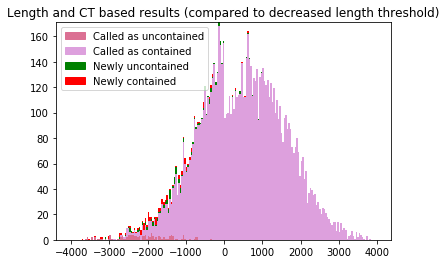

In [11]:
combinedYes = []
combinedNo = []
newKeep = []
newThrow = []
for i in range(0, len(lens)):
    a = names[i]
    b = nameToScore[a]
    ct = nameToThreshold[a]
    if lens[i] < x1:
        combinedNo.append(b)
    elif ct > lens[i] * slope + intercept:
        if lens[i] > lengthThreshold:
            newThrow.append(b)
        else:
            combinedNo.append(b)
    else:
        if lens[i] > lengthThreshold:
            combinedYes.append(b)
        else:
            newKeep.append(b)
            
numberContained = len(combinedNo) +  len(newThrow)
            
print('Number called as uncontained: ' + str(len(combinedYes) + len(newKeep)))
print('Number called as contained: ' + str(len(combinedNo) +  len(newThrow)))

colors = ['palevioletred', 'plum', 'green', 'red']
labels = ['Called as uncontained', 'Called as contained', 'Newly uncontained', 'Newly contained']
legendHandles = []
for i in range(0, len(colors)):
    legendHandles.append(mpatches.Patch(color=colors[i], label=labels[i]))
plt.title('Length and CT based results (compared to decreased length threshold)')
plt.hist([combinedYes, combinedNo, newKeep, newThrow], color = colors , bins = buckets, stacked = True)
plt.legend(handles=legendHandles)
plt.show()
plt.clf()
plt.cla()
plt.close()

## More Theoretical Results
Given a particular read with a fixed length, what is the probability of it being contained?  This is given by a formula which considers all possible placements of the start point of the containing read, and calculates the probability that the read is long enough to contain the given read.

Let P be the probability that a read R' contains a given read R of length L, and assume that the genome length is much larger than the read length (so edge effects can be ignored).  Then, we iterate over the length D by which the prefix of R' overhangs R, and add to R' the term 1 / genomeLength * p(len(R') >= len(R) + D), which can be computed using normal_cdf.  Then, the probability that R is uncontained is the probability that all other reads fail to contain it, or (1 - P) ^ N, where N is the total number of reads.  We assume for simplicity that since the genome length is much larger than the read length, the number of reads will get arbitrarily close to its expected value genomeLength * coverage / (mean read length), and use that value for N.

Now, because the genome length is so large, the probability of each read containing a given read will be small (but the number of reads is large enough that their aggregate probability is significant).  In order to reduce the impact of numerical stability on computing such probabilities, we add an additional assumption to obtain a closed form probability that a read is uncontained.  Let S be the summation used in the computation of P, ignoring the division by the length of the genome G (equal to P * G).  Then, the probability that R is uncontained is equal to (1 - (P / G)) ^ N.  This can be rewritten as (1 - (P / G)) ^ (G * C / M), where C is the coverage and M is the mean read length.  This is then equivalent to ((1 - (P / G)) ^ G) ^ (C / M), by properties of exponents, and the term ((1 - (P / G)) ^ G) is known to be e^(-P) as G approaches infinity, which we can use as a close approximation since G >> L.  Therefore, the probability that R is contained is 1 - (e ^ (-P * C / M)), and P can be calculated as the sum of normal_cdf terms as in the code below.

coverage = 15: 


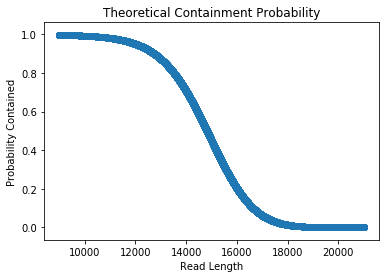

coverage = 30: 


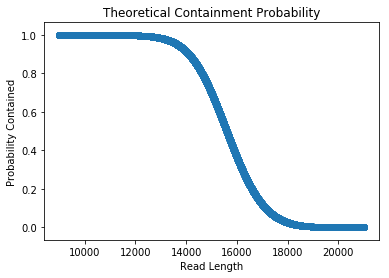

coverage = 60: 


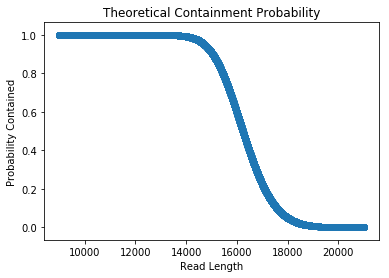

Standard deviation effects:


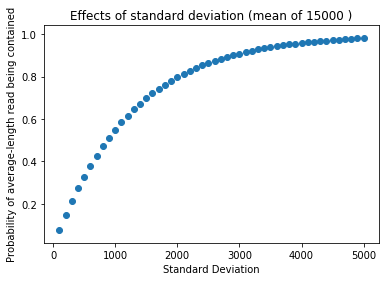

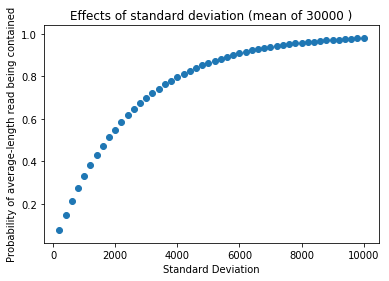

In [12]:
from math import *
def normalCdf(x):
    #'Cumulative distribution function for the standard normal distribution'
    return (1.0 + erf(x / sqrt(2.0))) / 2.0

def plot(genomeLength = 5000000, coverage = 30, mean = 15000, stdev = 1500, maxLen = 50000, min = 9000, max = 21000, verbose = False, ret = False):

    # The probability that a read is at least a given length
    probAtLeastLength = [0 for i in range(0,  maxLen+1)]
    for i in range(0, len(probAtLeastLength)):
        probAtLeastLength[i] = 1 - normalCdf((i - mean) / stdev)

    # The summation from i to maxLen of probAtLeastLength[i]
    # Used to speed up the computation of this summation
    cSum = [0 for i in range(0, len(probAtLeastLength))]
    cSum[len(cSum)-1] = probAtLeastLength[len(cSum) - 1]
    for i in range(len(cSum)-2, -1, -1):
        cSum[i] = cSum[i+1] + probAtLeastLength[i]

    pc = [0 for i in range(0,  maxLen+1)]

    lens = []
    pcs = []
    for L in range(min, max):
        sum = cSum[L+1]
        lens.append(L)
        prob = 1 - exp(-sum * coverage / mean)
        pcs.append(prob)
        pc[L] = prob
        if verbose and  (L % 1000 == 0):
            print("Length " + str(L) + " contained with probability " + str(prob))

    if not ret:
        plt.scatter(lens, pcs)
        plt.title('Theoretical Containment Probability')
        plt.xlabel('Read Length')
        plt.ylabel('Probability Contained')
        plt.show()
    if ret:
        return pcs[mean - min]
    
for cov in [15, 30, 60]:
    print('coverage = ' + str(cov) + ': ')
    plot(coverage = cov)

print('Standard deviation effects:')
for mu in [15000, 30000]:
    xs = []
    ys = []
    for st in range(int(mu/150), int(mu/150)*51, int(mu/150)):
        cur = plot(mean = mu, stdev = st, ret = True, min = mu - 100, max = mu + 100)
        xs.append(st)
        ys.append(cur)

    plt.scatter(xs, ys)
    plt.title('Effects of standard deviation (mean of ' + str(mu) + ' )')
    plt.xlabel('Standard Deviation')
    plt.ylabel('Probability of average-length read being contained')
    plt.show()


### A few observations
1. The probability of a read being uncontained given its length decreases exponentially with the coverage (i.e., doubling the coverage results in this probability being squared)
2. The probability of a read being contained given its length with a fixed coverage is independent of genome length as long as the genome length is sufficiently higher than the read length.
3. The probability of a read of average length being contained increases with the ratio of standard deviation to mean

## Looking at kmer frequencies

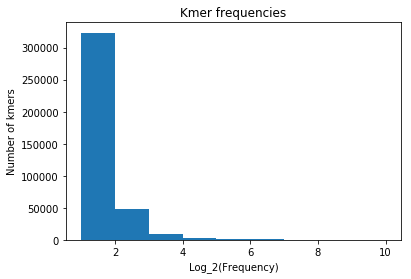

In [13]:
genomeFn  = 'simulatedgenome.txt'
kmerFreq = dict()
k = 15
with open(genomeFn) as f:
    for line in f:
        if line[0] == '>':
            continue
        for i in range(0, len(line) - k):
            cur = line[i:i+k]
            if not cur in kmerFreq:
                kmerFreq[cur] = 0
            kmerFreq[cur] = 1 + kmerFreq[cur]
            
fs = []
maxFreq = 0
maxLogFreq = 0
for x in kmerFreq:
    logFreq = log(kmerFreq[x], 2)
    if kmerFreq[x] > maxFreq:
        maxFreq = kmerFreq[x]
        maxLogFreq = logFreq
    fs.append(logFreq)
    
ff = [0 for i in range(0,  1 + maxFreq)]
for x in kmerFreq:
    cur = kmerFreq[x]
    ff[cur] = 1 + ff[cur]
for x in range(0, len(ff)):
    y = ff[x]
    if y == 0:
        continue
    #print(str(x) + ": " + str(y))
plt.hist(fs, bins = [i for i in range(1, 1+int(maxLogFreq))])
plt.title('Kmer frequencies')
plt.xlabel('Log_2(Frequency)')
plt.ylabel('Number of kmers')
plt.show()